# Exploratory Data Analysis (EDA) Exercise

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 2. Explore dataset

In [2]:
df = pd.read_excel("Test Data analyst EDA 2023.xlsx")
df.head()

,User ID,Acquired Campaign,Country,Platform,Device Model (OS),LTV Revenue,LTV Currency,Event Name,Event Date,Event Value (USD),Event Count
0,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,user_engagement,2021-08-29,NaN,5
1,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,screen_view,2021-08-29,NaN,4
2,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,session_start,2021-08-29,NaN,1
3,ZZZZC2DZ-982C-D4DD-C59Z-A8ZD0CBBA74F,(direct),Brazil,IOS,"iPhone9,3",NaN,NaN,login_help_screen_open,2021-08-29,NaN,2
4,ZZZ8F57Z-9EC6-3D44-BEAA-898829Z611ZA,(direct),United States,IOS,"iPhone12,1",NaN,NaN,screen_view,2021-09-02,NaN,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362515 entries, 0 to 362514
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   User ID            305349 non-null  object        
 1   Acquired Campaign  324462 non-null  object        
 2   Country            362495 non-null  object        
 3   Platform           362515 non-null  object        
 4   Device Model (OS)  362515 non-null  object        
 5   LTV Revenue        25690 non-null   float64       
 6   LTV Currency       25690 non-null   object        
 7   Event Name         362515 non-null  object        
 8   Event Date         362515 non-null  datetime64[ns]
 9   Event Value (USD)  634 non-null     float64       
 10  Event Count        362515 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 30.4+ MB


There are 11 columns that amount to upwards of 360k records. Each data column is consistent with their corresponding data type. The next step requires us to clean the data in order to properly make an assessment of the information provided.

## 3. Cleanup of data

Establishing which columns have null values, and if so how many, should be the first course of action. We'll handle each column case by case.

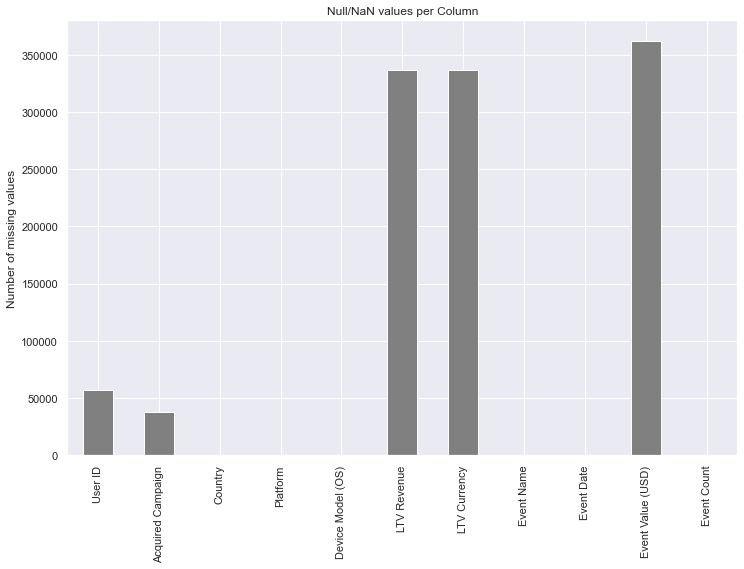

In [4]:
sns.set(rc={'figure.figsize':(12,8)})
pd.isnull(df).sum().plot(kind='bar', color='gray')
plt.ylabel('Number of missing values')
plt.title('Null/NaN values per Column')
plt.show()

*User ID*, *Acquired Campaign*, *LTV Revenue*, *LTV Currency* and *Event Value (USD)* have some form of null/NaN records.

### Consistency check:

- Given that there are null User IDs, but the data attached to those records might have relevant information, it would be wise to keep them as is; taking into account that they could affect some analysis moving forward. Other judgement can decide _not_ to include them for the sake of avoiding corruped data, but evidence suggests that this could've been a issue when it came to collecting the IDs. For instance, there are LTV Revenue numbers with no User IDs, and, if discarded, could create a mismatch between the raw data and finance numbers down the line.

In [5]:
df['LTV Revenue'][(df['User ID'].isnull()) & (df['LTV Revenue'].notnull())].count()

691

In [6]:
null_ids = df[df['User ID'].isnull()].shape[0] / df.shape[0] * 100
print(f"Approximately {null_ids:.2f}% of User IDs are null")

Approximately 15.77% of User IDs are null


- Knowing that ALL null values from 'Acquired Campaign' come from Android devices and none from iOS, and that their User IDs suggest that they might come from Instagram, I took it upon myself to declare them as 'Android Instagram w/o Launch' in an attempt to improve the value of the data.

In [7]:
print("Null values from iOS:", df[(df['Acquired Campaign'].isnull()) & (df['Platform'] == "IOS")].shape[0], '. Null values from Android:', df[(df['Acquired Campaign'].isnull()) & (df['Platform'] == "ANDROID")].shape[0])

Null values from iOS: 0 . Null values from Android: 38053


In [8]:
df['Acquired Campaign'] = np.where(df['Acquired Campaign'].isnull(), 'Android Instagram w/o Launch', df['Acquired Campaign'])

- Confirm consistency between LTV Revenue and its currency, should the case be that some records return revenue w/o currency OR currency w/o revenue.

In [9]:
df[(df['LTV Revenue'].notnull()) & (df['LTV Currency'].isnull())]

,User ID,Acquired Campaign,Country,Platform,Device Model (OS),LTV Revenue,LTV Currency,Event Name,Event Date,Event Value (USD),Event Count


In [10]:
df[(df['LTV Revenue'].isnull()) & (df['LTV Currency'].notnull())]

,User ID,Acquired Campaign,Country,Platform,Device Model (OS),LTV Revenue,LTV Currency,Event Name,Event Date,Event Value (USD),Event Count


- Confirm that there aren't Event Values (USD) associated with non-purchase related Events.

In [11]:
df['Event Name'][(df['Event Value (USD)'].notnull())].unique()

array(['in_app_purchase'], dtype=object)

- Check duplicated data

In [12]:
df.duplicated().sum()

0

## 4. Exploratory Data Analysis (EDA)

Now that we've sanitized our dataset, it's time to dive in and see if we can get a good understanding of the use of the app and the purchases made. We'll provide insight and suggestions when we see fit.

### a. Devices, Platforms & Campaigns

Mobile devices from Apple have codifications regarding their device types, so I renamed the top ones in order to recognize which is which. See reference at https://gist.github.com/adamawolf/3048717

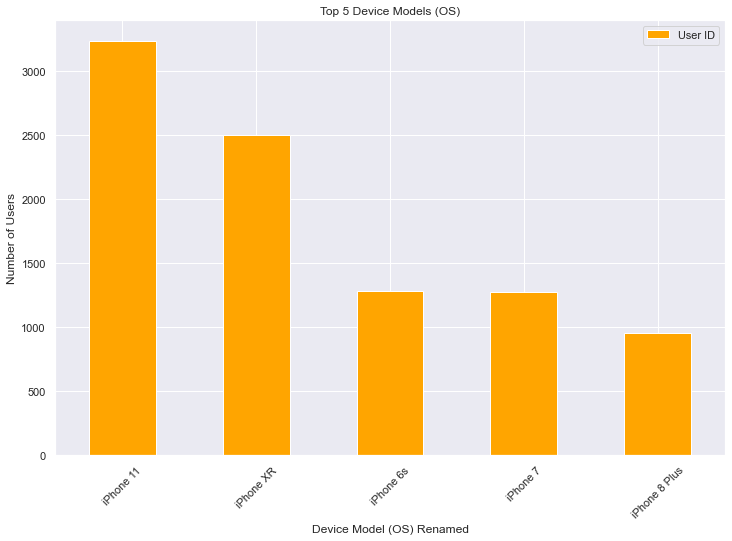

In [13]:
td = df[['User ID', 'Device Model (OS)']].drop_duplicates()

top_devices = td.groupby('Device Model (OS)')['User ID'].nunique().sort_values(ascending=False).reset_index().head(5)

conditions = [
    (top_devices['Device Model (OS)'] == 'iPhone12,1'),
    (top_devices['Device Model (OS)'] == 'iPhone11,8'),
    (top_devices['Device Model (OS)'] == 'iPhone8,1'),
    (top_devices['Device Model (OS)'] == 'iPhone9,3'),
    (top_devices['Device Model (OS)'] == 'iPhone10,5')
]
values = ['iPhone 11','iPhone XR','iPhone 6s', 'iPhone 7', 'iPhone 8 Plus']

top_devices['Device Model (OS) Renamed'] = np.select(conditions, values)

top_devices.set_index(['Device Model (OS) Renamed'], inplace=True)
top_devices.plot(kind='bar', figsize=(12, 8), color='orange')
plt.title('Top 5 Device Models (OS)')
plt.xticks(rotation=45)
plt.ylabel('Number of Users')
plt.show()

Most of the iOS traffic comes directly from the iPhone models, with iPad devices having very little impact. On the other hand, the XIAOMI Redmi devices are the most popular following the iPhone, and even still the Redmi Note 8  barely covers **16%** of the iPhone 11's audience. But outside of the top countries, namely US and Brazil, is where we'll see other device models pop up a lot more. So, for instance:

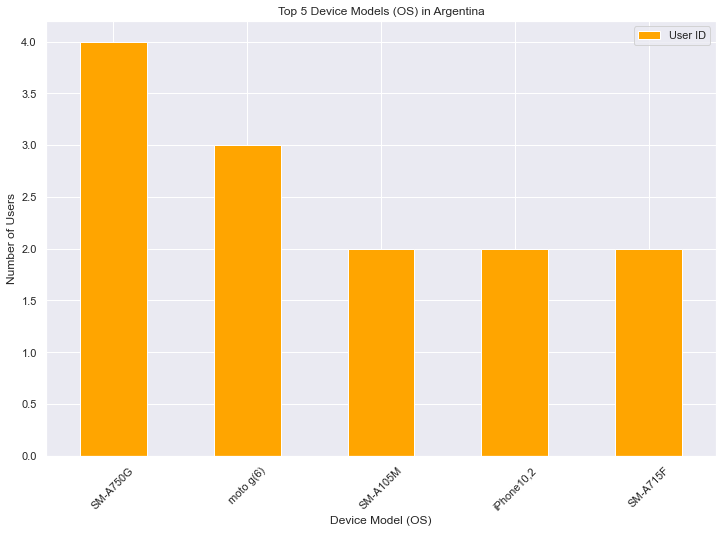

In [14]:
td_country= df[df['Country'] == 'Argentina']
td = td_country[['User ID', 'Device Model (OS)']].drop_duplicates()

top_devices = td.groupby('Device Model (OS)')['User ID'].nunique().sort_values(ascending=False).reset_index().head(5)

top_devices.set_index(['Device Model (OS)'], inplace=True)
top_devices.plot(kind='bar', figsize=(12, 8), color='orange')
plt.title('Top 5 Device Models (OS) in Argentina')
plt.xticks(rotation=45)
plt.ylabel('Number of Users')
plt.show()

Device models on a country with less purchasing power and more import restrictions, such as Argentina, will most likely have lower-end/budget-tier mobile phones as their top devices. This is something to take into account when measuring new markets overseas.

Now onto the operating systems.

Here there are a few caveats to be wary of. In the definition of the table structure, it is stated that every LTV Revenue is unique to each user, meaning that for every User ID there is only one revenue number attached to them. However, this isn't always the case. From a total of 1493 unique users that generated revenue, there were 350 that had at least more than one LTV Revenue number. This implies that some more context is needed for the following graph, in which we look at the OS that generated the most revenue.

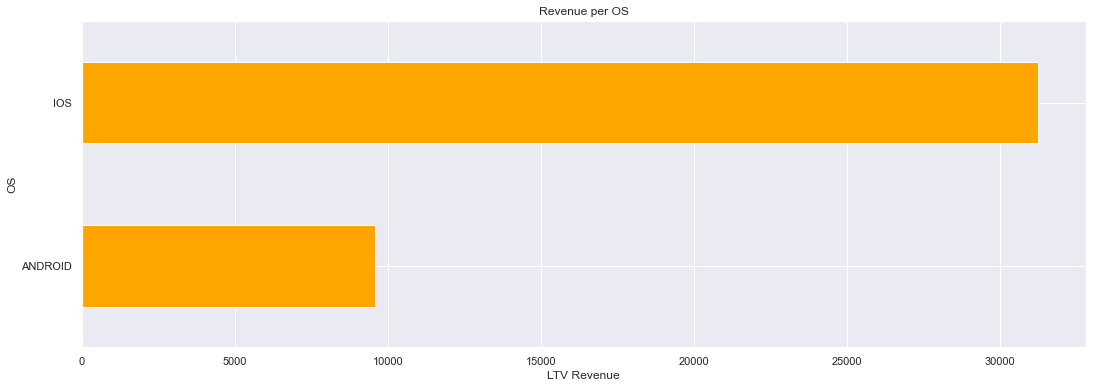

In [15]:
pr = df[['User ID', 'Platform', 'LTV Revenue']].drop_duplicates()

platform_revenue = pr.groupby('Platform')['LTV Revenue'].sum()

platform_revenue.plot(kind='barh', figsize=(18, 6), color='orange')
plt.title('Revenue per OS')
plt.xlabel('LTV Revenue')
plt.ylabel('OS')
plt.show()

And even still, by quite the difference, iOS generated more revenue than Android, about x3. Maybe this is not because Apple users are necessarily more profitable to the company, but more so because the iOS audience is inherently larger than Android. So, essentially, a scaling effect.

Now, while still looking at both OS, we jump from one revenue metric to the other. An histogram of their *Event Value (USD)* could be a good way to find out how much, and how many times, users from each platform spend inside the app.

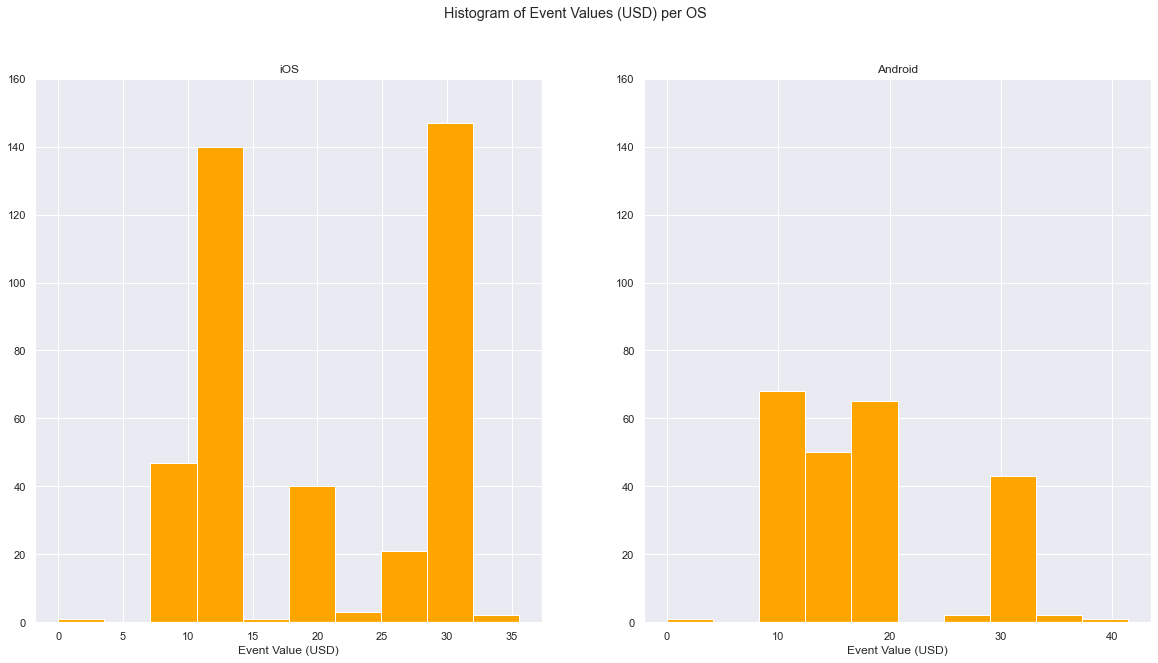

In [16]:
ev = df[['Country', 'Event Name', 'Event Value (USD)']]
ev = ev[ev['Event Value (USD)'].notnull()].sort_values(by='Event Value (USD)', ascending=False)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
ev['Event Value (USD)'][df['Platform'] == "IOS"].hist(color='orange')
plt.title('iOS')
plt.xlabel('Event Value (USD)')
plt.ylim(0.0, 160)

plt.subplot(1, 2, 2)
ev['Event Value (USD)'][df['Platform'] == "ANDROID"].hist(color='orange')
plt.title('Android')
plt.xlabel('Event Value (USD)')
plt.ylim(0.0, 160)

plt.suptitle('Histogram of Event Values (USD) per OS')
plt.show()

Both operating systems might appear to have different distributions in terms of their spending pattern, however they range approximately between $10 and $30. iOS seems to have the most expenditure on either side of the extremes, while Android seems to concentrate more on the lower end of that range, between $10 and $20. Nevertheless, the visible scale difference between graphs is corresponding to the amount of device models in each OS. Again, scaling effect.

Now onto the acquired campaigns.

When evaluating the sources through which a user is acquired, _Direct_ was evidently the top one. But besides _Direct_, there were also many other sources only made up of strings, such as `iOS_US_Eng_Actions_Hard_Launch`, whose value could be extracted through their relevant information, in this case being Apple's operating system (_iOS_) and the launch campaign (_Hard_).

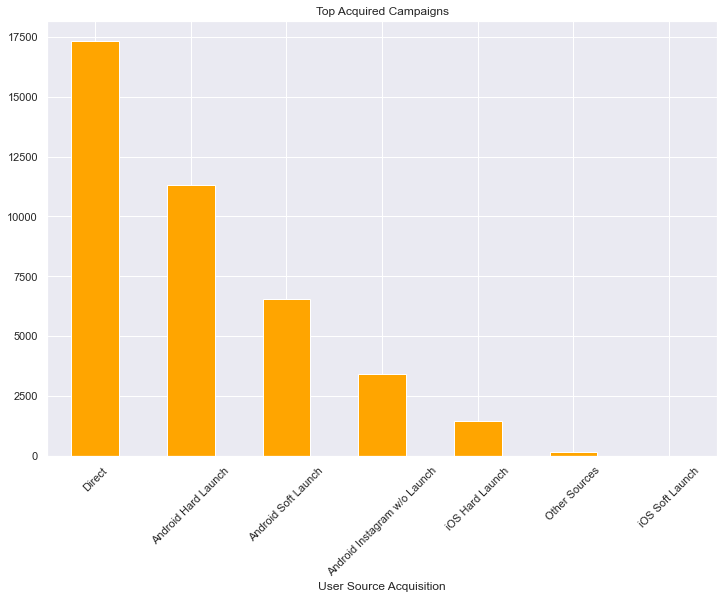

In [17]:
cp = df[['User ID', 'Acquired Campaign']].drop_duplicates()

conditions = [
    (cp['Acquired Campaign'] == '(direct)'),
    (cp['Acquired Campaign'].str.contains('and', case=False, na=False)) & (cp['Acquired Campaign'].str.contains('soft', case=False, na=False)),
    (cp['Acquired Campaign'].str.contains('and', case=False, na=False)) & (cp['Acquired Campaign'].str.contains('hard', case=False, na=False)),
    (cp['Acquired Campaign'].str.contains('ios', case=False, na=False)) & (cp['Acquired Campaign'].str.contains('soft', case=False, na=False)),
    (cp['Acquired Campaign'].str.contains('ios', case=False, na=False)) & (cp['Acquired Campaign'].str.contains('hard', case=False, na=False)),
    (cp['Acquired Campaign'] == 'iOS_US_Eng_Actions') | (cp['Acquired Campaign'] == 'AND_BR_Por_Actions') | (cp['Acquired Campaign'] == 'AND_US_Eng_Actions'),
    (cp['Acquired Campaign'] == 'Android Instagram w/o Launch') # Previous category created for null values
]

values = ['Direct','Android Soft Launch','Android Hard Launch', 'iOS Soft Launch', 'iOS Hard Launch', 'Other Sources', 'Android Instagram w/o Launch']
cp['User Source Acquisition'] = np.select(conditions, values)

campaign = cp.groupby('User Source Acquisition')['User ID'].nunique().sort_values(ascending=False)
campaign.plot(kind='bar', color='orange', figsize=(12,8))
plt.xticks(rotation=45)
plt.title('Top Acquired Campaigns')
plt.show()

Now in terms of the revenue they generate:

In [18]:
revenue_source = df.merge(cp, how='left', on=['User ID', 'Acquired Campaign'])

revenue_source = revenue_source[revenue_source['LTV Revenue'].notnull()]
revenue_source = revenue_source[['User ID', 'LTV Revenue', 'User Source Acquisition']].drop_duplicates()

revenue_source = revenue_source.groupby('User Source Acquisition')['LTV Revenue'].sum().sort_values(ascending=False).reset_index()
revenue_source['Percentage (%) of LTV Revenue'] = round(((revenue_source['LTV Revenue'] / revenue_source['LTV Revenue'].sum()) * 100), 2)
revenue_source['LTV Revenue'] = revenue_source['LTV Revenue'].map('${:,.2f}'.format)
revenue_source

,User Source Acquisition,LTV Revenue,Percentage (%) of LTV Revenue
0,Direct,"$30,149.91",73.82
1,Android Hard Launch,"$5,298.14",12.97
2,Android Instagram w/o Launch,"$3,698.06",9.05
3,iOS Hard Launch,$712.61,1.74
4,Android Soft Launch,$504.19,1.23
5,Other Sources,$470.77,1.15
6,iOS Soft Launch,$6.49,0.02


It's clear that _Direct_ makes up most of the LTV Revenue  numbers. However, even though a source such as *Android Soft Launch* is the 3rd most popular method of acquiring a user, it represents barely a **2%** of the total revenue. Is there a marketing campaign cost when it comes to the soft launch of the app on Android? This may be something to think about.

The previously null values, now labeled as "_Android Instagram w/o Launch_", amount to $3.7k USD; which means that they're most likely coming from a hard launch campaign. It also implies that there might be an issue related to how the data is gathered for a subgroup of Android devices on Instagram. *A reminder that some of these results have the previously mentioned issue regarding LTV Revenue.

### b. Events, In-app Purchases & Countries

Initially, I suspected that there might be a dependency or sequentiality among the events and their order; which is why I did a quick check on this topic.

I wanted to find out if, for each _"User ID"_ / _"Event Date"_ that has at least one event attached, there is always at least a `screen_view` event. This happens in **97%** of the cases recorded, which highly suggests that this affirmation might be true. This means that, in order to properly gain insight into these events, it would be good to know how this dependency functions.

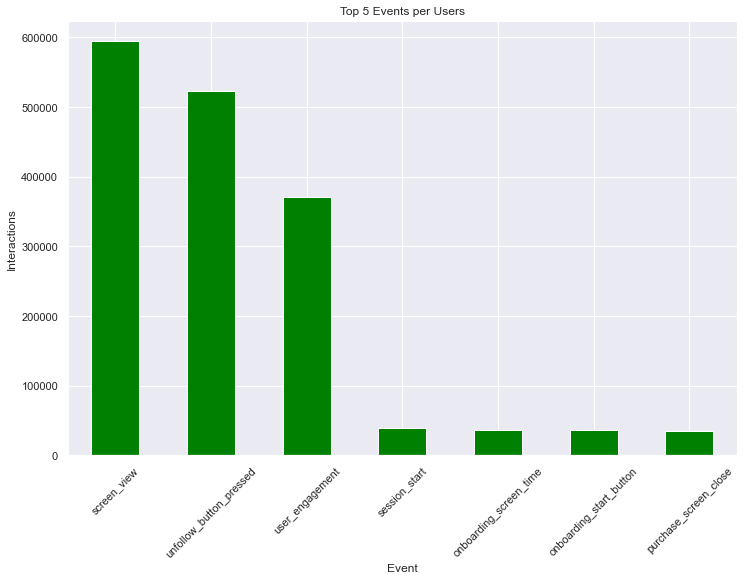

In [19]:
te = df[['User ID', 'Event Name', 'Event Count']].drop_duplicates()

top_events = te.groupby('Event Name')['Event Count'].sum().sort_values(ascending=False).head(7)

top_events.plot(kind='bar', figsize=(12, 8), color='green')
plt.title('Top 5 Events per Users')
plt.xlabel('Event')
plt.xticks(rotation=45)
plt.ylabel('Interactions')
plt.show()

Taking into consideration the possibility of dependency of events over `screen_view`, the fact that it tops the list of most frequent event tracks perfectly; but it also implies that there isn't much to take away from it. The next most frquent event, `unfollow_button_pressed`, poses a more interesting question. Is there a decrease in interest/interaction among users and their posts if what they do the most is unfollow other users? Another thing to consider.

Also, the dataset having just about over a month worth of data is enough to let us timeline the event revenue, which is seen as follows:

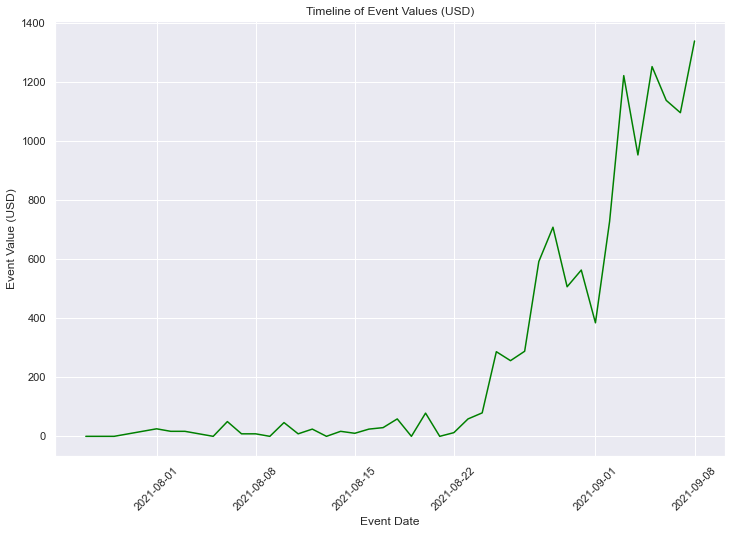

In [20]:
revenue_over_dates = df.groupby('Event Date')['Event Value (USD)'].sum()

plt.figure(figsize=(12, 8))
plt.plot(revenue_over_dates.index, revenue_over_dates.values, color='green')
plt.xlabel('Event Date')
plt.ylabel('Event Value (USD)')
plt.xticks(rotation=45)
plt.title('Timeline of Event Values (USD)')
plt.show()

In detail, this graph timelines the sum of the event values over the dates of event occurences. The last few weeks saw a surge in event revenue, and in an effort to try to make sense of this, I analyzed the data by way of segmenting various categories in the timeline: country, platform, campaign, among others. In every case the situation remained similar, which suggests that this surge was most likely caused by an exogenous factor. This could've been any sort of successful promotional material, a seasonal effect in consumer behaviour, etc.

Now moving onto how countries interact with the app:

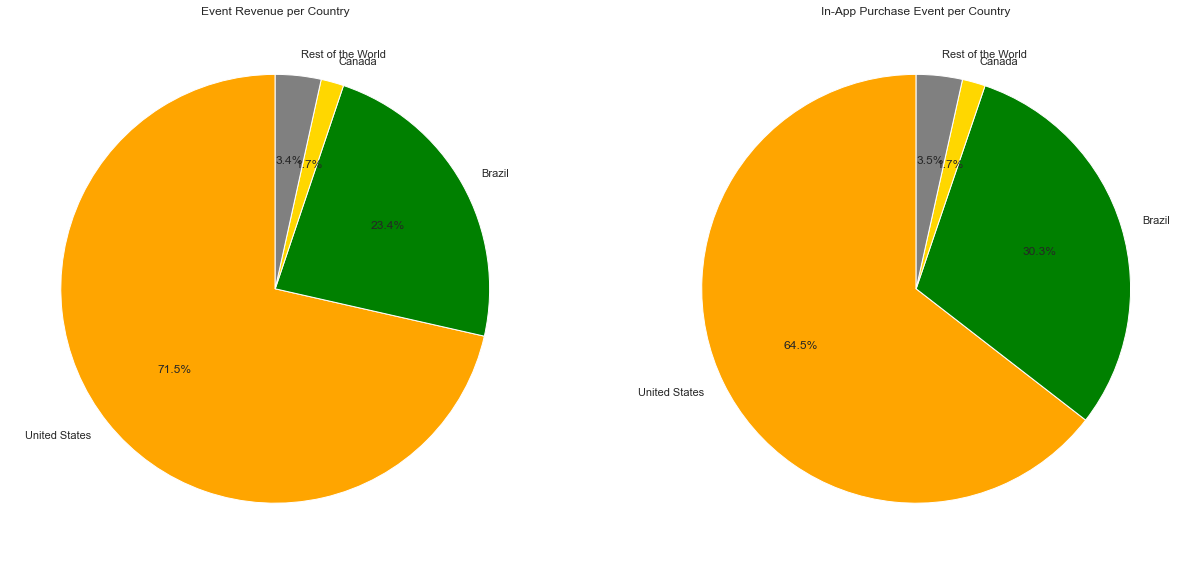

In [21]:
cr = df[['User ID', 'Country', 'Event Value (USD)']].drop_duplicates()
country_revenue = cr.groupby('Country')['Event Value (USD)'].sum().sort_values(ascending=False)
country_revenue = country_revenue.reset_index()

rest_world = country_revenue.iloc[3:]
total_rest_world_rev = rest_world['Event Value (USD)'].sum()
country_revenue = country_revenue.iloc[:3]

new_data_rev = {'Country': 'Rest of the World', 'Event Value (USD)': total_rest_world_rev}
country_revenue = country_revenue.append(new_data_rev, ignore_index=True)

##################################################################################################

iap = df[['User ID', 'Country', 'Event Name']].drop_duplicates()
in_app_purchase = iap[iap['Event Name'] == 'in_app_purchase']
country_in_app = in_app_purchase['Country'].value_counts()
country_in_app = country_in_app.reset_index()

rest_world = country_in_app.iloc[3:]
total_rest_world_ev = rest_world['Country'].sum()
country_in_app = country_in_app.iloc[:3]

new_data_ev = {'index': 'Rest of the World', 'Country': total_rest_world_ev}
country_in_app = country_in_app.append(new_data_ev, ignore_index=True)
country_in_app.rename(columns={'index': 'Country', 'Country': 'Purchase Events'}, inplace=True)

##################################################################################################

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
colors = ['orange', 'green', 'gold', 'grey']

plt.subplot(1, 2, 1)
plt.pie(country_revenue['Event Value (USD)'], labels=country_revenue['Country'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Event Revenue per Country')

plt.subplot(1, 2, 2)
plt.pie(country_in_app['Purchase Events'], labels=country_in_app['Country'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('In-App Purchase Event per Country')

plt.tight_layout()
plt.show()

A side by side comparison of the countries' event revenue and purchase events (`in_app_purchase`) should give us some perspective; mostly about the users interaction with purchase events in relation to how much they actually *do*. For instance, although Brazil holds about a third of the total interactions of purchase events (*Graph 2*), they have proportionally less expenditure when it comes to the revenue these events create (*Graph 1*). And the opposite could be said about the US. These observations are explored further with the following table:

In [22]:
total_events  = df[['User ID', 'Country', 'Event Name', 'Event Date', 'Event Count']]
total_events = total_events.groupby('Country')['Event Count'].sum().sort_values(ascending=False).reset_index()
total_events.rename(columns={'Event Count': 'Total Events'}, inplace=True)

remunerated_events = df[df['Event Value (USD)'].notnull()]
remunerated_events = remunerated_events.groupby('Country')['Event Count'].sum().reset_index()
remunerated_events.rename(columns={'Event Count': 'Remunerated Events'}, inplace=True)

total_events = total_events.merge(remunerated_events, how='left', on='Country')
total_events['Remunerated Events'] = np.where(total_events['Remunerated Events'].isnull(), 0, total_events['Remunerated Events'])
total_events

total_events['Remunerated Ratio'] = (total_events['Remunerated Events'] / total_events['Total Events']) * 100
total_events = total_events.sort_values(by='Total Events', ascending=False).head(10)
total_events.sort_values(by='Remunerated Ratio', ascending=False)

,Country,Total Events,Remunerated Events,Remunerated Ratio
8,Canada,8003,11.0,0.137448
1,United States,640805,409.0,0.063826
0,Brazil,1200403,192.0,0.015995
3,Spain,43692,4.0,0.009155
2,India,199533,5.0,0.002506
4,Indonesia,13106,0.0,0.000000
5,Pakistan,13056,0.0,0.000000
6,Philippines,11898,0.0,0.000000
7,South Africa,8194,0.0,0.000000
9,Malaysia,6295,0.0,0.000000


From the top 10 countries that have the most traffic, we look at the ratio between their events and the purchase-related events. Canada only has a fraction of the total events that countries such as the US and Brazil have, and yet are proportionally a lot more likely to engage in a remunerated event. Canada could therefore be a potential market to explore further.

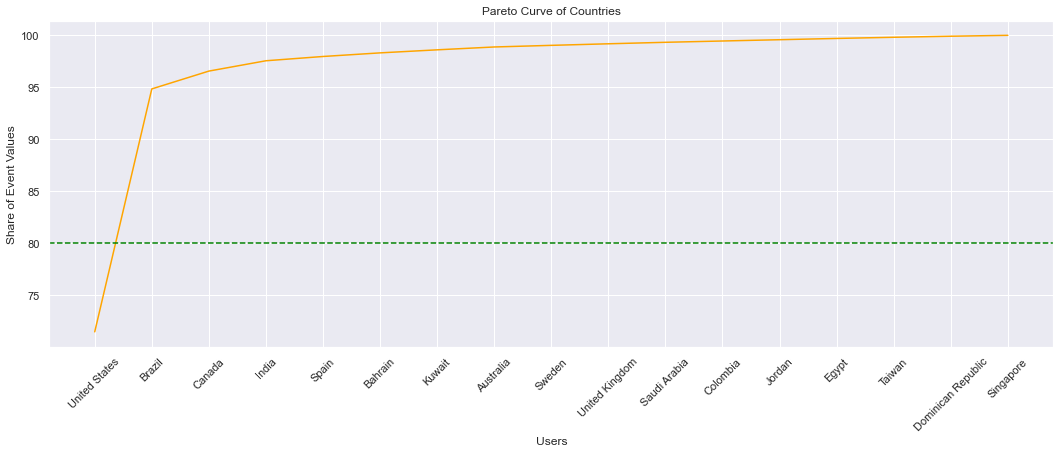

In [23]:
pareto = df[df['Event Name'] == 'in_app_purchase']

pareto = pareto.groupby(['Country'])['Event Value (USD)'].sum().sort_values(ascending=False).reset_index()
pareto['Cumulative Pareto Curve'] = pareto['Event Value (USD)'].cumsum()/pareto['Event Value (USD)'].sum()*100
pareto.set_index('Country', inplace=True)

plt.figure(figsize=(18, 6))
plt.plot(pareto.index, pareto['Cumulative Pareto Curve'], color='orange')
plt.axhline(y=80, color='green', linestyle='--')
plt.xlabel('Users')
plt.xticks(rotation=45)
plt.ylabel('Share of Event Values')
plt.title('Pareto Curve of Countries')
plt.show()

Both pie charts piqued my interest regarding how these countries are concentrated in terms of their event values. An interesting quantification of shared concentration to plot would therefore be the **Pareto Curve**. It makes sense that the US and Brazil represent a joint **94.84%** of the total revenue generated from these events. But as we can see in the Pareto curve, and knowing that Canada is already an important part of the client portfolio, the graph reaffirms the previous suggestion that there is a big opportunity to exploit in that country.

All of these graphs are just some examples of exploratory analysis that I thought could be interesting to look at.

LP.